In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="4"

import argparse
import torch
import torchvision
import torch.nn.functional as F
import numpy as np

from nn.enums import ExplainingMethod
from nn.networks import ExplainableNet
from nn.utils import get_expl, plot_overview, clamp, load_image, make_dir

no display found. Using non-interactive Agg backend


In [2]:
def get_beta(i, num_iter):
    """
    Helper method for beta growth
    """
    start_beta, end_beta = 10.0, 100.0
    return start_beta * (end_beta / start_beta) ** (i / num_iter)

def np_img_to_tensor(grayscale_img):
    rgb_img = np.repeat(grayscale_img[..., np.newaxis], 3, -1)
    im = Image.fromarray(rgb_img)
    x = torchvision.transforms.Normalize(mean=data_mean, std=data_std)(torchvision.transforms.ToTensor()(torchvision.transforms.Resize(224)(im)))
    x = x.unsqueeze(0).to(device)
    return x

In [3]:
# args
args_cuda = True
args_method = 'lrp'
args_beta_growth = None
args_num_iter = 1500
args_prefactors = [1e11, 1e6]
args_lr = 0.0002
args_output_dir = '../output/'

In [4]:
# options
device = torch.device("cuda" if args_cuda else "cpu")
method = getattr(ExplainingMethod, args_method)
print('Explanation method {} will be used'.format(method))

# load model
data_mean = np.array([0.0, 0.0, 0.0])
data_std = np.array([1.0, 1.0, 1.0])

vgg_model = torchvision.models.vgg16(pretrained=True)
model = ExplainableNet(vgg_model, data_mean=data_mean, data_std=data_std, beta=1000 if args_beta_growth else None)
if method == ExplainingMethod.pattern_attribution:
    model.load_state_dict(torch.load('../models/model_vgg16_pattern_small.pth'), strict=False)
model = model.eval().to(device)

print(vgg_model)

Explanation method ExplainingMethod.lrp will be used
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Max

In [5]:
import keras
from keras import datasets 
(x_train, y_train) ,(x_test, y_test) = datasets.fashion_mnist.load_data()
from torchvision import datasets, transforms
from PIL import Image

x = np_img_to_tensor(x_train[0])
x_adv = x.clone().detach().requires_grad_()
print(x.shape)
org_expl, org_acc, org_idx = get_expl(model, x, method)
org_expl = org_expl.detach().cpu()

# The class from which we will derive the target explanation
source_class_idx = 6
# pick index of x_train where the label is that of the source class
idx = np.where(y_train == source_class_idx)[0][0]
grayscale_img_src = x_train[idx]
x_target = np_img_to_tensor(grayscale_img_src)
target_expl, _, _ = get_expl(model, x_target, method)
target_expl = target_expl.detach()

Using TensorFlow backend.
/home/raj_vardhan/anaconda3/envs/torch_env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/raj_vardhan/anaconda3/envs/torch_env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/raj_vardhan/anaconda3/envs/torch_env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1

torch.Size([1, 3, 224, 224])


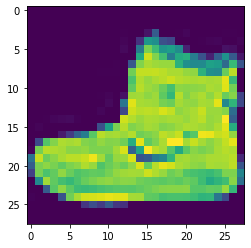

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(x_train[0])

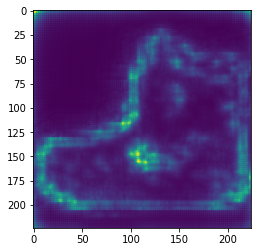

In [7]:
#.data[0].cpu().numpy()
org_expl_np = org_expl.cpu().numpy()
plt.imshow(org_expl_np[0])

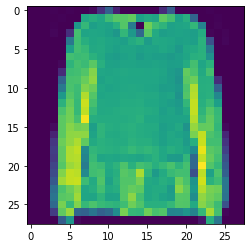

In [8]:
plt.imshow(grayscale_img_src)

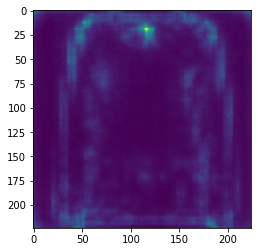

In [9]:
target_expl_np = target_expl.cpu().numpy()
plt.imshow(target_expl_np[0])

In [10]:
optimizer = torch.optim.Adam([x_adv], lr=args_lr)

for i in range(args_num_iter):
    if args_beta_growth:
        model.change_beta(get_beta(i, args_num_iter))

    optimizer.zero_grad()

    # calculate loss
    adv_expl, adv_acc, class_idx = get_expl(model, x_adv, method, desired_index=org_idx)
    loss_expl = F.mse_loss(adv_expl, target_expl)
    loss_output = F.mse_loss(adv_acc, org_acc.detach())
    total_loss = args_prefactors[0]*loss_expl + args_prefactors[1]*loss_output

    # update adversarial example
    total_loss.backward()
    optimizer.step()

    # clamp adversarial example
    # Note: x_adv.data returns tensor which shares data with x_adv but requires
    #       no gradient. Since we do not want to differentiate the clamping,
    #       this is what we need
    x_adv.data = clamp(x_adv.data, data_mean, data_std)

    print("Iteration {}: Total Loss: {}, Expl Loss: {}, Output Loss: {}".format(i, total_loss.item(), loss_expl.item(), loss_output.item()))

Iteration 0: Total Loss: 79.43865966796875, Expl Loss: 7.943866120463383e-10, Output Loss: 0.0
Iteration 1: Total Loss: 78.11853790283203, Expl Loss: 7.74159070182634e-10, Output Loss: 7.026321782177547e-07
Iteration 2: Total Loss: 77.60809326171875, Expl Loss: 7.688648051562552e-10, Output Loss: 7.216128778964048e-07
Iteration 3: Total Loss: 76.31684875488281, Expl Loss: 7.606132945703337e-10, Output Loss: 2.5552503757353406e-07
Iteration 4: Total Loss: 75.43798828125, Expl Loss: 7.530132073441109e-10, Output Loss: 1.3666709719473147e-07
Iteration 5: Total Loss: 74.92101287841797, Expl Loss: 7.451149142134739e-10, Output Loss: 4.0952403423943906e-07
Iteration 6: Total Loss: 74.03287506103516, Expl Loss: 7.390629219727884e-10, Output Loss: 1.265857605403653e-07
Iteration 7: Total Loss: 73.40857696533203, Expl Loss: 7.331347195993487e-10, Output Loss: 9.510478093943675e-08
Iteration 8: Total Loss: 72.87608337402344, Expl Loss: 7.267758617146569e-10, Output Loss: 1.9850173771374102e-07
I

Iteration 74: Total Loss: 46.58586883544922, Expl Loss: 4.592453084484305e-10, Output Loss: 6.613369691876869e-07
Iteration 75: Total Loss: 46.276065826416016, Expl Loss: 4.562538402641536e-10, Output Loss: 6.506834324682131e-07
Iteration 76: Total Loss: 45.96720504760742, Expl Loss: 4.5301123963170653e-10, Output Loss: 6.660791314061498e-07
Iteration 77: Total Loss: 45.650718688964844, Expl Loss: 4.496563399403186e-10, Output Loss: 6.850846716588421e-07
Iteration 78: Total Loss: 45.393672943115234, Expl Loss: 4.466809144787476e-10, Output Loss: 7.255821969920362e-07
Iteration 79: Total Loss: 45.085994720458984, Expl Loss: 4.4368006490991263e-10, Output Loss: 7.179890531006095e-07
Iteration 80: Total Loss: 44.75962448120117, Expl Loss: 4.403617470671861e-10, Output Loss: 7.234485224216769e-07
Iteration 81: Total Loss: 44.42783737182617, Expl Loss: 4.373515161137931e-10, Output Loss: 6.926879336788261e-07
Iteration 82: Total Loss: 44.103275299072266, Expl Loss: 4.3412246020224643e-10, O

Iteration 146: Total Loss: 26.118244171142578, Expl Loss: 2.5097537936780157e-10, Output Loss: 1.0207055538558052e-06
Iteration 147: Total Loss: 25.82481575012207, Expl Loss: 2.485354977377341e-10, Output Loss: 9.71265762927942e-07
Iteration 148: Total Loss: 25.6544246673584, Expl Loss: 2.464451143158186e-10, Output Loss: 1.0099151950271334e-06
Iteration 149: Total Loss: 25.474323272705078, Expl Loss: 2.4439025803069114e-10, Output Loss: 1.0352964636695106e-06
Iteration 150: Total Loss: 25.270591735839844, Expl Loss: 2.4223004158052674e-10, Output Loss: 1.04758737506927e-06
Iteration 151: Total Loss: 25.0346736907959, Expl Loss: 2.405163568308666e-10, Output Loss: 9.830378076003399e-07
Iteration 152: Total Loss: 24.88138198852539, Expl Loss: 2.389308195738238e-10, Output Loss: 9.882998028842849e-07
Iteration 153: Total Loss: 24.692428588867188, Expl Loss: 2.3646970492841035e-10, Output Loss: 1.0454571111040423e-06
Iteration 154: Total Loss: 24.4881534576416, Expl Loss: 2.34609220939319

Iteration 218: Total Loss: 14.688716888427734, Expl Loss: 1.3907117124567492e-10, Output Loss: 7.815995104465401e-07
Iteration 219: Total Loss: 14.588641166687012, Expl Loss: 1.3808929000269643e-10, Output Loss: 7.797129910613876e-07
Iteration 220: Total Loss: 14.493953704833984, Expl Loss: 1.372991442760707e-10, Output Loss: 7.640394983354781e-07
Iteration 221: Total Loss: 14.392976760864258, Expl Loss: 1.3635409468193416e-10, Output Loss: 7.575671361337299e-07
Iteration 222: Total Loss: 14.30832576751709, Expl Loss: 1.3561589351507308e-10, Output Loss: 7.46736418477667e-07
Iteration 223: Total Loss: 14.210269927978516, Expl Loss: 1.346837502635978e-10, Output Loss: 7.418944960591034e-07
Iteration 224: Total Loss: 14.12779712677002, Expl Loss: 1.3393275377637792e-10, Output Loss: 7.345215635723434e-07
Iteration 225: Total Loss: 14.038933753967285, Expl Loss: 1.330980325953135e-10, Output Loss: 7.29130306353909e-07
Iteration 226: Total Loss: 13.94544506072998, Expl Loss: 1.322273124326

Iteration 290: Total Loss: 10.582474708557129, Expl Loss: 1.0014672424674131e-10, Output Loss: 5.678020329469291e-07
Iteration 291: Total Loss: 10.544293403625488, Expl Loss: 9.980431758815911e-11, Output Loss: 5.638614197778224e-07
Iteration 292: Total Loss: 10.510746002197266, Expl Loss: 9.946290319140516e-11, Output Loss: 5.644557745654311e-07
Iteration 293: Total Loss: 10.483695030212402, Expl Loss: 9.91930287908005e-11, Output Loss: 5.643922236231447e-07
Iteration 294: Total Loss: 10.4429931640625, Expl Loss: 9.881048063098419e-11, Output Loss: 5.619447733806737e-07
Iteration 295: Total Loss: 10.403801918029785, Expl Loss: 9.843749426696746e-11, Output Loss: 5.600528538707295e-07
Iteration 296: Total Loss: 10.356851577758789, Expl Loss: 9.79662323485897e-11, Output Loss: 5.602285000350093e-07
Iteration 297: Total Loss: 10.32278823852539, Expl Loss: 9.76302372279747e-11, Output Loss: 5.597646008936863e-07
Iteration 298: Total Loss: 10.28905200958252, Expl Loss: 9.732869371559261e-1

Iteration 362: Total Loss: 8.501323699951172, Expl Loss: 8.007189356007416e-11, Output Loss: 4.9413455371905e-07
Iteration 363: Total Loss: 8.483778953552246, Expl Loss: 7.984057859289351e-11, Output Loss: 4.997208407075959e-07
Iteration 364: Total Loss: 8.459220886230469, Expl Loss: 7.960483661140216e-11, Output Loss: 4.987369948139531e-07
Iteration 365: Total Loss: 8.426513671875, Expl Loss: 7.935898466149283e-11, Output Loss: 4.906153776573774e-07
Iteration 366: Total Loss: 8.399303436279297, Expl Loss: 7.91117379939088e-11, Output Loss: 4.881298423242697e-07
Iteration 367: Total Loss: 8.380043983459473, Expl Loss: 7.888383696252887e-11, Output Loss: 4.916606144433899e-07
Iteration 368: Total Loss: 8.363636016845703, Expl Loss: 7.870178120317206e-11, Output Loss: 4.934586286253762e-07
Iteration 369: Total Loss: 8.34206771850586, Expl Loss: 7.850570193923545e-11, Output Loss: 4.91497644361516e-07
Iteration 370: Total Loss: 8.314087867736816, Expl Loss: 7.82768710960724e-11, Output Lo

Iteration 434: Total Loss: 7.202990531921387, Expl Loss: 6.762731347143003e-11, Output Loss: 4.4025944134773454e-07
Iteration 435: Total Loss: 7.188179016113281, Expl Loss: 6.754498349526017e-11, Output Loss: 4.336812082783581e-07
Iteration 436: Total Loss: 7.1733503341674805, Expl Loss: 6.743006153442366e-11, Output Loss: 4.3034393115704006e-07
Iteration 437: Total Loss: 7.16203498840332, Expl Loss: 6.72806116375213e-11, Output Loss: 4.339739803072007e-07
Iteration 438: Total Loss: 7.149278163909912, Expl Loss: 6.713567896055039e-11, Output Loss: 4.357104614882701e-07
Iteration 439: Total Loss: 7.129551410675049, Expl Loss: 6.697813137446218e-11, Output Loss: 4.3173844233024283e-07
Iteration 440: Total Loss: 7.110525131225586, Expl Loss: 6.682353281828313e-11, Output Loss: 4.2817211465262517e-07
Iteration 441: Total Loss: 7.098188877105713, Expl Loss: 6.669261670699811e-11, Output Loss: 4.2892722262877214e-07
Iteration 442: Total Loss: 7.081721782684326, Expl Loss: 6.650460737667174e-

Iteration 506: Total Loss: 6.348138332366943, Expl Loss: 5.960482107880694e-11, Output Loss: 3.876563710036862e-07
Iteration 507: Total Loss: 6.343782901763916, Expl Loss: 5.949993969744938e-11, Output Loss: 3.937894064165448e-07
Iteration 508: Total Loss: 6.336301803588867, Expl Loss: 5.939777142360825e-11, Output Loss: 3.965247969972552e-07
Iteration 509: Total Loss: 6.322349548339844, Expl Loss: 5.934459867962261e-11, Output Loss: 3.878899690334947e-07
Iteration 510: Total Loss: 6.3105549812316895, Expl Loss: 5.92208157512708e-11, Output Loss: 3.884737225234858e-07
Iteration 511: Total Loss: 6.307230472564697, Expl Loss: 5.91346763223477e-11, Output Loss: 3.9376325844386884e-07
Iteration 512: Total Loss: 6.2925028800964355, Expl Loss: 5.902612426611498e-11, Output Loss: 3.898906300037197e-07
Iteration 513: Total Loss: 6.276573657989502, Expl Loss: 5.89212151291818e-11, Output Loss: 3.8445247696472507e-07
Iteration 514: Total Loss: 6.270388603210449, Expl Loss: 5.884161213831618e-11,

Iteration 578: Total Loss: 5.701575756072998, Expl Loss: 5.356827134650466e-11, Output Loss: 3.447484004936996e-07
Iteration 579: Total Loss: 5.699368953704834, Expl Loss: 5.349913220764613e-11, Output Loss: 3.494558029615291e-07
Iteration 580: Total Loss: 5.694957733154297, Expl Loss: 5.3388651138908116e-11, Output Loss: 3.560927837042982e-07
Iteration 581: Total Loss: 5.677649021148682, Expl Loss: 5.329837265977133e-11, Output Loss: 3.4781172075781797e-07
Iteration 582: Total Loss: 5.662235736846924, Expl Loss: 5.320456922253136e-11, Output Loss: 3.417787297621544e-07
Iteration 583: Total Loss: 5.66005802154541, Expl Loss: 5.31310273554908e-11, Output Loss: 3.4695523254413274e-07
Iteration 584: Total Loss: 5.650908470153809, Expl Loss: 5.301900585230612e-11, Output Loss: 3.4900833156825684e-07
Iteration 585: Total Loss: 5.637796878814697, Expl Loss: 5.294493315988191e-11, Output Loss: 3.433036965816427e-07
Iteration 586: Total Loss: 5.625000953674316, Expl Loss: 5.2855747556534993e-1

Iteration 650: Total Loss: 5.150909423828125, Expl Loss: 4.8336962904516056e-11, Output Loss: 3.172128231199167e-07
Iteration 651: Total Loss: 5.148126125335693, Expl Loss: 4.828799513023618e-11, Output Loss: 3.193270288193162e-07
Iteration 652: Total Loss: 5.143162250518799, Expl Loss: 4.8222467685654635e-11, Output Loss: 3.209156318462192e-07
Iteration 653: Total Loss: 5.140087604522705, Expl Loss: 4.817056475925341e-11, Output Loss: 3.2303162811331276e-07
Iteration 654: Total Loss: 5.135192394256592, Expl Loss: 4.810697326607105e-11, Output Loss: 3.2449551667923515e-07
Iteration 655: Total Loss: 5.131048679351807, Expl Loss: 4.803839964706569e-11, Output Loss: 3.2720885201342753e-07
Iteration 656: Total Loss: 5.1301727294921875, Expl Loss: 4.801387412656233e-11, Output Loss: 3.287853473921132e-07
Iteration 657: Total Loss: 5.121197700500488, Expl Loss: 4.789272450844706e-11, Output Loss: 3.3192549153682194e-07
Iteration 658: Total Loss: 5.120399475097656, Expl Loss: 4.78729451913739

Iteration 722: Total Loss: 4.8273797035217285, Expl Loss: 4.425294505838728e-11, Output Loss: 4.020854760256043e-07
Iteration 723: Total Loss: 4.7101969718933105, Expl Loss: 4.417101753806385e-11, Output Loss: 2.930950131485588e-07
Iteration 724: Total Loss: 4.745678424835205, Expl Loss: 4.412777088180775e-11, Output Loss: 3.3290143619524315e-07
Iteration 725: Total Loss: 4.810330867767334, Expl Loss: 4.407918821613954e-11, Output Loss: 4.0241204146695964e-07
Iteration 726: Total Loss: 4.792153358459473, Expl Loss: 4.403218067938752e-11, Output Loss: 3.88935518458311e-07
Iteration 727: Total Loss: 4.7031168937683105, Expl Loss: 4.3970695140505e-11, Output Loss: 3.0604758194385795e-07
Iteration 728: Total Loss: 4.6910080909729, Expl Loss: 4.39191079337764e-11, Output Loss: 2.9909750765000354e-07
Iteration 729: Total Loss: 4.735863208770752, Expl Loss: 4.386957463964336e-11, Output Loss: 3.489062407879828e-07
Iteration 730: Total Loss: 4.722262382507324, Expl Loss: 4.3828801699064e-11, O

Iteration 794: Total Loss: 4.764670372009277, Expl Loss: 4.134382072806808e-11, Output Loss: 6.30288525371725e-07
Iteration 795: Total Loss: 4.479286193847656, Expl Loss: 4.1323614669019904e-11, Output Loss: 3.469247928933328e-07
Iteration 796: Total Loss: 4.782374858856201, Expl Loss: 4.130626049536623e-11, Output Loss: 6.517485076074081e-07
Iteration 797: Total Loss: 4.402154922485352, Expl Loss: 4.124623559365048e-11, Output Loss: 2.77531711390111e-07
Iteration 798: Total Loss: 4.722649574279785, Expl Loss: 4.124376881686764e-11, Output Loss: 5.982726634101709e-07
Iteration 799: Total Loss: 4.414546966552734, Expl Loss: 4.117366864120342e-11, Output Loss: 2.971799233364436e-07
Iteration 800: Total Loss: 4.5873332023620605, Expl Loss: 4.1151033969288875e-11, Output Loss: 4.7222994226103765e-07
Iteration 801: Total Loss: 4.444000720977783, Expl Loss: 4.114081297856842e-11, Output Loss: 3.299191746464203e-07
Iteration 802: Total Loss: 4.484976768493652, Expl Loss: 4.109322257472847e-11

Iteration 866: Total Loss: 4.082293510437012, Expl Loss: 3.8303926003235844e-11, Output Loss: 2.5190081487380667e-07
Iteration 867: Total Loss: 4.077515125274658, Expl Loss: 3.825689071090821e-11, Output Loss: 2.518258952477481e-07
Iteration 868: Total Loss: 4.072835445404053, Expl Loss: 3.821117727786927e-11, Output Loss: 2.51717722221656e-07
Iteration 869: Total Loss: 4.0671515464782715, Expl Loss: 3.8157185744402966e-11, Output Loss: 2.514330503800011e-07
Iteration 870: Total Loss: 4.063679218292236, Expl Loss: 3.8125003154476644e-11, Output Loss: 2.511790171411121e-07
Iteration 871: Total Loss: 4.058389186859131, Expl Loss: 3.807362064511821e-11, Output Loss: 2.510269894173689e-07
Iteration 872: Total Loss: 4.053627967834473, Expl Loss: 3.802791068152622e-11, Output Loss: 2.508370471332455e-07
Iteration 873: Total Loss: 4.049479007720947, Expl Loss: 3.798929920639793e-11, Output Loss: 2.5054887942133064e-07
Iteration 874: Total Loss: 4.045588970184326, Expl Loss: 3.7953418186020826

Iteration 938: Total Loss: 4.157987117767334, Expl Loss: 3.6046922391452796e-11, Output Loss: 5.532949103326246e-07
Iteration 939: Total Loss: 3.8520491123199463, Expl Loss: 3.602231360422259e-11, Output Loss: 2.4981795831990894e-07
Iteration 940: Total Loss: 3.989894390106201, Expl Loss: 3.598864956044778e-11, Output Loss: 3.9102971527427144e-07
Iteration 941: Total Loss: 4.045074462890625, Expl Loss: 3.599276085508585e-11, Output Loss: 4.457982925032411e-07
Iteration 942: Total Loss: 3.834474802017212, Expl Loss: 3.5958052507778504e-11, Output Loss: 2.3866959963925183e-07
Iteration 943: Total Loss: 3.97100567817688, Expl Loss: 3.591325500873488e-11, Output Loss: 3.7968010246913764e-07
Iteration 944: Total Loss: 3.9466118812561035, Expl Loss: 3.587847033359459e-11, Output Loss: 3.587649928249448e-07
Iteration 945: Total Loss: 3.82824444770813, Expl Loss: 3.585542973638667e-11, Output Loss: 2.4270153176075837e-07
Iteration 946: Total Loss: 3.9477713108062744, Expl Loss: 3.5821623445286

Iteration 1010: Total Loss: 3.575914144515991, Expl Loss: 3.356134814502809e-11, Output Loss: 2.1977943731599225e-07
Iteration 1011: Total Loss: 3.571570873260498, Expl Loss: 3.351952743146924e-11, Output Loss: 2.1961817253668414e-07
Iteration 1012: Total Loss: 3.5678389072418213, Expl Loss: 3.348404539749161e-11, Output Loss: 2.1943441197436186e-07
Iteration 1013: Total Loss: 3.5662126541137695, Expl Loss: 3.3470323734796636e-11, Output Loss: 2.1918040715718234e-07
Iteration 1014: Total Loss: 3.562366485595703, Expl Loss: 3.3434463531101244e-11, Output Loss: 2.18920106931364e-07
Iteration 1015: Total Loss: 3.5569329261779785, Expl Loss: 3.3382838160456174e-11, Output Loss: 2.1864919119707338e-07
Iteration 1016: Total Loss: 3.5544073581695557, Expl Loss: 3.335990858555071e-11, Output Loss: 2.1841650266196666e-07
Iteration 1017: Total Loss: 3.551368236541748, Expl Loss: 3.333152157058983e-11, Output Loss: 2.182162148756106e-07
Iteration 1018: Total Loss: 3.5476419925689697, Expl Loss: 3

Iteration 1082: Total Loss: 3.4040615558624268, Expl Loss: 3.194334727285586e-11, Output Loss: 2.0972689185327908e-07
Iteration 1083: Total Loss: 3.4021494388580322, Expl Loss: 3.190149186482749e-11, Output Loss: 2.1200035860147182e-07
Iteration 1084: Total Loss: 3.3926398754119873, Expl Loss: 3.188103253615182e-11, Output Loss: 2.0453657612051757e-07
Iteration 1085: Total Loss: 3.393707036972046, Expl Loss: 3.184860014604496e-11, Output Loss: 2.0884714047042507e-07
Iteration 1086: Total Loss: 3.3904521465301514, Expl Loss: 3.182260704948092e-11, Output Loss: 2.0819133794702793e-07
Iteration 1087: Total Loss: 3.384347438812256, Expl Loss: 3.18083615002962e-11, Output Loss: 2.0351114926597802e-07
Iteration 1088: Total Loss: 3.384533643722534, Expl Loss: 3.1773365188891844e-11, Output Loss: 2.0719711812944297e-07
Iteration 1089: Total Loss: 3.3795993328094482, Expl Loss: 3.17382960191015e-11, Output Loss: 2.0576986514697637e-07
Iteration 1090: Total Loss: 3.3732237815856934, Expl Loss: 3

Iteration 1154: Total Loss: 3.3572816848754883, Expl Loss: 3.0122123545472945e-11, Output Loss: 3.450693384365877e-07
Iteration 1155: Total Loss: 3.5416693687438965, Expl Loss: 3.014303043280542e-11, Output Loss: 5.273662964100367e-07
Iteration 1156: Total Loss: 3.338932752609253, Expl Loss: 3.014068855611285e-11, Output Loss: 3.248639472985815e-07
Iteration 1157: Total Loss: 3.2285237312316895, Expl Loss: 3.014447025329048e-11, Output Loss: 2.1407683448160242e-07
Iteration 1158: Total Loss: 3.416594982147217, Expl Loss: 3.014163571513073e-11, Output Loss: 4.0243151033791946e-07
Iteration 1159: Total Loss: 3.3189778327941895, Expl Loss: 3.011649957196383e-11, Output Loss: 3.0732786626685993e-07
Iteration 1160: Total Loss: 3.213803768157959, Expl Loss: 3.010127910818561e-11, Output Loss: 2.0367608044580265e-07
Iteration 1161: Total Loss: 3.3548495769500732, Expl Loss: 3.008356411204893e-11, Output Loss: 3.464932945007604e-07
Iteration 1162: Total Loss: 3.274696111679077, Expl Loss: 3.00

Iteration 1226: Total Loss: 3.03145170211792, Expl Loss: 2.850466737647217e-11, Output Loss: 1.8098488396844914e-07
Iteration 1227: Total Loss: 3.031235694885254, Expl Loss: 2.850429614564831e-11, Output Loss: 1.8080606878356775e-07
Iteration 1228: Total Loss: 3.0288894176483154, Expl Loss: 2.8483325073547228e-11, Output Loss: 1.8055692407870083e-07
Iteration 1229: Total Loss: 3.0246505737304688, Expl Loss: 2.844382368527576e-11, Output Loss: 1.8026827319772565e-07
Iteration 1230: Total Loss: 3.0203826427459717, Expl Loss: 2.840417658023231e-11, Output Loss: 1.7996491408212023e-07
Iteration 1231: Total Loss: 3.0181055068969727, Expl Loss: 2.838407113514574e-11, Output Loss: 1.7969857424304791e-07
Iteration 1232: Total Loss: 3.0147080421447754, Expl Loss: 2.835221120378595e-11, Output Loss: 1.7948688935121027e-07
Iteration 1233: Total Loss: 3.0111987590789795, Expl Loss: 2.8318812572702967e-11, Output Loss: 1.7931736806531262e-07
Iteration 1234: Total Loss: 3.0085079669952393, Expl Loss

Iteration 1298: Total Loss: 2.893916368484497, Expl Loss: 2.719626607250447e-11, Output Loss: 1.7428963872134773e-07
Iteration 1299: Total Loss: 2.9040815830230713, Expl Loss: 2.7167896404778347e-11, Output Loss: 1.8729218709268025e-07
Iteration 1300: Total Loss: 2.8918051719665527, Expl Loss: 2.7151102546807415e-11, Output Loss: 1.766948543036051e-07
Iteration 1301: Total Loss: 2.886345148086548, Expl Loss: 2.7127775720225955e-11, Output Loss: 1.7356755677155888e-07
Iteration 1302: Total Loss: 2.89294171333313, Expl Loss: 2.7103061114863713e-11, Output Loss: 1.8263557421960286e-07
Iteration 1303: Total Loss: 2.882505416870117, Expl Loss: 2.707003024515764e-11, Output Loss: 1.7550263464727323e-07
Iteration 1304: Total Loss: 2.8773603439331055, Expl Loss: 2.704612922510563e-11, Output Loss: 1.727472920265427e-07
Iteration 1305: Total Loss: 2.8815369606018066, Expl Loss: 2.702382935482195e-11, Output Loss: 1.7915415639890853e-07
Iteration 1306: Total Loss: 2.875530242919922, Expl Loss: 2

Iteration 1370: Total Loss: 3.2708423137664795, Expl Loss: 2.581050304040211e-11, Output Loss: 6.897921593917999e-07
Iteration 1371: Total Loss: 3.40592885017395, Expl Loss: 2.5803201589291724e-11, Output Loss: 8.256086516666983e-07
Iteration 1372: Total Loss: 3.0263302326202393, Expl Loss: 2.5798738145788036e-11, Output Loss: 4.464563971851021e-07
Iteration 1373: Total Loss: 2.7487359046936035, Expl Loss: 2.5785776291975537e-11, Output Loss: 1.701583585145272e-07
Iteration 1374: Total Loss: 2.8941688537597656, Expl Loss: 2.5774212625284676e-11, Output Loss: 3.1674761657995987e-07
Iteration 1375: Total Loss: 2.995222806930542, Expl Loss: 2.5767719555314095e-11, Output Loss: 4.1845089526759693e-07
Iteration 1376: Total Loss: 2.8432929515838623, Expl Loss: 2.576320753955308e-11, Output Loss: 2.6697222210714244e-07
Iteration 1377: Total Loss: 2.7506070137023926, Expl Loss: 2.5767847924851317e-11, Output Loss: 1.7382222949891002e-07
Iteration 1378: Total Loss: 2.8713412284851074, Expl Loss

Iteration 1442: Total Loss: 2.6208741664886475, Expl Loss: 2.463675964625711e-11, Output Loss: 1.5719828638793842e-07
Iteration 1443: Total Loss: 2.619626522064209, Expl Loss: 2.4624339026169118e-11, Output Loss: 1.5719272994374478e-07
Iteration 1444: Total Loss: 2.617074728012085, Expl Loss: 2.4598422257438024e-11, Output Loss: 1.572325629695115e-07
Iteration 1445: Total Loss: 2.6171905994415283, Expl Loss: 2.4598848999413114e-11, Output Loss: 1.5730579150385893e-07
Iteration 1446: Total Loss: 2.6139657497406006, Expl Loss: 2.456423085772652e-11, Output Loss: 1.5754261539768777e-07
Iteration 1447: Total Loss: 2.614016532897949, Expl Loss: 2.4560804778861467e-11, Output Loss: 1.5793608554304228e-07
Iteration 1448: Total Loss: 2.6115827560424805, Expl Loss: 2.4528200651130483e-11, Output Loss: 1.5876277359438973e-07
Iteration 1449: Total Loss: 2.6127190589904785, Expl Loss: 2.4525003555764258e-11, Output Loss: 1.6021871829252632e-07
Iteration 1450: Total Loss: 2.6137490272521973, Expl L

In [11]:
# test with original model (with relu activations)
model.change_beta(None)
adv_expl, adv_acc, class_idx = get_expl(model, x_adv, method)

# save results
output_dir = make_dir(args_output_dir)
plot_overview([x_target, x, x_adv], [target_expl, org_expl, adv_expl], data_mean, data_std, filename=f"{output_dir}overview_{args_method}.png")
torch.save(x_adv, f"{output_dir}x_{args_method}.pth")

# Retrieve the resulting adversarial example

In [15]:
from PIL import Image
import random

In [19]:
side = 28
x_adv2_big = x_adv.detach().cpu().numpy()

im2 = Image.fromarray(x_adv2_big[0][0])
x_adv2_small = torchvision.transforms.ToTensor()(torchvision.transforms.Resize(side)(im2))
x_adv2_small_np = x_adv2_small.numpy()
x_adv2_small_np = x_adv2_small_np.reshape(side, side)

This is the adv_2 adversarial example which produces the target map by the target explanation method


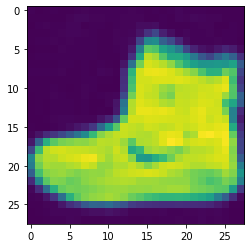

In [21]:
print('This is the adv_2 adversarial example which produces the target map by the target explanation method')
plt.imshow(x_adv2_small_np)

In [25]:
adv2 = x_adv2_small_np * 255.0/np.max(x_adv2_small_np)